In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
import numpy as np
from framed.io.sbml import sanitize_id
import reframed
from reframed.cobra.ensemble import load_ensemble
import cobra
from cobra.io import read_sbml_model
import pandas as pd

In [2]:
modelFiles = '*.xml.gz'
df = pd.DataFrame(columns=['reaction']) 
Dataframes=[]
for modelF in glob(modelFiles): #for each model
    if "Ensemble" not in modelF:
        model=read_sbml_model(modelF) #read model 
        model.optimize()
        modelSpecificRxs=[]
        for rxID in model.reactions:
            modelSpecificRxs.append(rxID.id)
        ModelSpecificData=[]
        for rx in modelSpecificRxs:
            OneRow=[rx, True]
            ModelSpecificData.append(OneRow)
        modelF=modelF.replace(".xml.gz", '')
        modelSpecificDF=pd.DataFrame(ModelSpecificData, columns=['reaction', modelF])  
        Dataframes.append(modelSpecificDF)
        
for each_DF in Dataframes:
    df=pd.merge(each_DF, df, on='reaction', how='outer').fillna(False)
# df       

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
BinaryGramRxs=df*1 #from bool values to binary values
BinaryGramRxs=BinaryGramRxs.set_index('reaction')
# BinaryGramRxs.sort_index(inplace=True)
# BinaryGramRxs

In [4]:
BinaryGramRxs["number of models"] = BinaryGramRxs.sum(axis=1) 

BinaryGramRxs_sorted= BinaryGramRxs.sort_values(by=['number of models'])

BinaryGramRxs_sorted = BinaryGramRxs_sorted[(BinaryGramRxs_sorted['number of models'] != 0) & (BinaryGramRxs_sorted['number of models'] != len(BinaryGramRxs_sorted.iloc[:,:-1].columns))]
# BinaryGramRxs_sorted

In [6]:
NeuroactiveDF=pd.read_excel('allNeuroRxsIds.xlsx')
# TransportersDF=pd.read_excel('transporters.xlsx')
TransportersDF=pd.read_excel('UnivNGramTranspRxs.xlsx', index_col=0)
ExchangesDF=pd.read_excel('exchanges.xlsx')


NeuroactiveIDs=NeuroactiveDF.ReactionID.unique()
TransportersIDs=TransportersDF.ReactionID.unique()
# print(len(TransportersIDs))
ExchangesIDs=ExchangesDF.ReactionID.unique()
# print(len(ExchangesDF))

BinaryGramDiffRxs=BinaryGramRxs_sorted.copy()
RxTypes=[]
# for index, rows in BinaryGramDiffRxs.iterrows():    
# #     if index in TransportersIDs:
# #         RxTypes.append("Transp")
# #     elif index in ExchangesIDs:
# #         RxTypes.append("Ex")
# #     elif index in NeuroactiveIDs:
#     if index in NeuroactiveIDs:
#         RxTypes.append("Neuro")
#     else:
#         RxTypes.append(" ")
        
for index, rows in BinaryGramDiffRxs.iterrows():
    if index in NeuroactiveIDs:
        RxTypes.append("Neuro")
    elif index in TransportersIDs:
        RxTypes.append("Transp")
    elif index in ExchangesIDs:
        RxTypes.append("Ex")
    else:
        RxTypes.append(" ")

#     if index in NeuroactiveIDs:
# #         print("Yes, 'at' found in List : " )
# #     else:
# #         print('NOT found in List :' )

In [7]:
BinaryGramDiffRxs["ReactionType"]=RxTypes
BinaryGramDiffRxs.index = BinaryGramDiffRxs.index.map(str) + " " + BinaryGramDiffRxs["ReactionType"].map(str)
# pd.set_option('display.max_rows', None)
# print(BinaryGramDiffRxs.ReactionType)


In [8]:
BinaryGramRxs_binarySorted=BinaryGramDiffRxs.copy()
BinaryGramRxs_binarySorted=BinaryGramRxs_binarySorted.drop(columns=['number of models', 'ReactionType'])
# BinaryGramRxs_binarySorted

In [9]:
BinaryGramRxs_binarySorted = BinaryGramRxs_binarySorted.rename(columns={"carve_LBmedium_gram_Btheta": "gram_LB_noGap", "LBmedium_Btheta_gram_gapFilled_during": "gram_LB_gapDuring", "LBmedium_Btheta_gapFilled_during": "U_LB_gapDuring", "LBmedium_Btheta_gapFilled_after": "U_LB_gapAfter","Btheta_gram_gapFilled_during": "gram_M9_gapDuring", "carve_Btheta": "U_M9_noGap", 'Btheta_gram_gapFilled_after': 'gram_M9_gapAfter','carve_LBmedium_Btheta': 'U_LB_noGap', "carve_gram_Btheta": "gram_M9_noGap", "LBmedium_Btheta_gram_gapFilled_after": "gram_LB_gapAfter", 'Btheta_gapFilled_after':'U_M9_gapAfter', 'Btheta_gapFilled_during':'U_M9_gapDuring'})
BinaryGramRxs_binarySorted = BinaryGramRxs_binarySorted.reindex(sorted(BinaryGramRxs_binarySorted.columns), axis=1)
BinaryGramRxs_binarySorted.sort_index(inplace=True)
# BinaryGramRxs_binarySorted

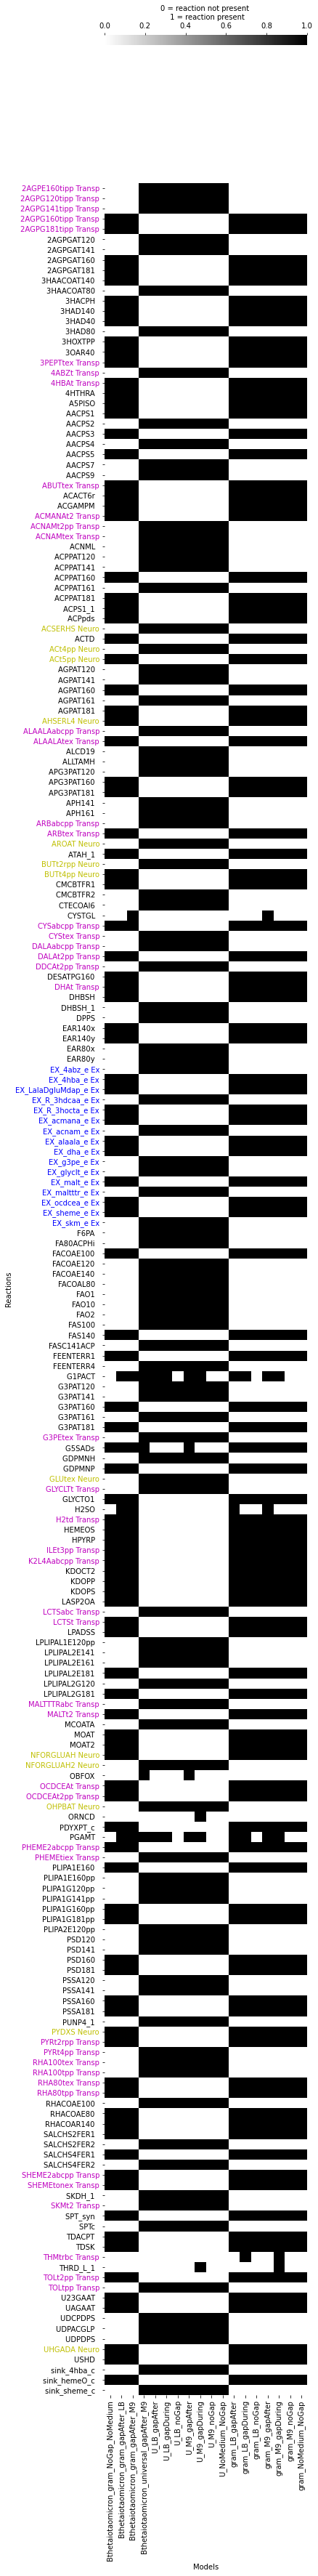

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (5,70))

# font = {'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)

s=sns.heatmap(BinaryGramRxs_binarySorted, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = reaction not present \n 1 = reaction present', 'location': 'top'}, linewidth=0)
s.set(xlabel='Models', ylabel='Reactions')

for l in s.xaxis.get_ticklabels()+s.yaxis.get_ticklabels():
    if 'Transp' in l.get_text():
        l.set_color('m')
    elif 'Ex' in l.get_text():
        l.set_color('b')
    elif 'Neuro' in l.get_text():
        l.set_color('y')

# plt.savefig('AllModelsRxsDiffs_alphabetically.pdf', format="pdf",bbox_inches="tight")

#### How growth reactions differ in terms of metabolites between every model

In [42]:
modelFiles = '*.xml.gz'
GrowthDF = pd.DataFrame(columns=['metabolites']) 
GrowthDataframes=[]
for modelF in glob(modelFiles): #for each model
    if "Ensemble" not in modelF:
        model=read_sbml_model(modelF) #read model 
        GrowthMetabs=[]
        for metabID in model.reactions.get_by_id('Growth').metabolites:
            GrowthMetabs.append(metabID.id)
        GrowthData=[]
        for metab in GrowthMetabs:
            dfRow=[metab, True]
            GrowthData.append(dfRow)
        modelF=modelF.replace(".xml.gz", '')
        ModelSpecificGrowthDF=pd.DataFrame(GrowthData, columns=['metabolites', modelF])  
        GrowthDataframes.append(ModelSpecificGrowthDF)
        
for eachDF in GrowthDataframes:
    GrowthDF=pd.merge(eachDF, GrowthDF, on='metabolites', how='outer').fillna(False)
# GrowthDF 

In [43]:
BinaryGramRxs=GrowthDF*1 #from bool values to binary values
BinaryGramRxs=BinaryGramRxs.set_index('metabolites')
# BinaryGramRxs

BinaryGramRxs["number of models"] = BinaryGramRxs.sum(axis=1) 

BinaryGramRxs_sorted= BinaryGramRxs.sort_values(by=['number of models'])
BinaryGramRxs_sorted

,carve_Btheta,carve_LBmedium_gram_Btheta,carve_LBmedium_Btheta,carve_gram_Btheta,Btheta_gapFilled_after,LBmedium_Btheta_gram_gapFilled_during,LBmedium_Btheta_gapFilled_during,LBmedium_Btheta_gapFilled_after,Btheta_gram_gapFilled_during,Btheta_gram_gapFilled_after,Btheta_gapFilled_during,LBmedium_Btheta_gram_gapFilled_after,number of models
metabolites,,,,,,,,,,,,,
sheme_c,0,1,0,1,0,1,0,0,1,1,0,1,6
uaagmda_c,1,0,1,0,1,0,1,1,0,0,1,0,6
kdo2lipid4_p,0,1,0,1,0,1,0,0,1,1,0,1,6
murein5px4p_p,0,1,0,1,0,1,0,0,1,1,0,1,6
pheme_c,0,1,0,1,0,1,0,0,1,1,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ile__L_c,1,1,1,1,1,1,1,1,1,1,1,1,12
k_c,1,1,1,1,1,1,1,1,1,1,1,1,12
leu__L_c,1,1,1,1,1,1,1,1,1,1,1,1,12


In [44]:

NotAllDF=BinaryGramRxs_sorted[(BinaryGramRxs_sorted['number of models'] != 0) & (BinaryGramRxs_sorted['number of models'] != len(BinaryGramRxs_sorted.iloc[:,:-1].columns))]
# (BinaryGramRxs_sorted['number of models'] != 0) & (BinaryGramRxs_sorted['number of models'] != len(BinaryGramRxs_sorted.iloc[:,:-1].columns))
NotAllDF

,carve_Btheta,carve_LBmedium_gram_Btheta,carve_LBmedium_Btheta,carve_gram_Btheta,Btheta_gapFilled_after,LBmedium_Btheta_gram_gapFilled_during,LBmedium_Btheta_gapFilled_during,LBmedium_Btheta_gapFilled_after,Btheta_gram_gapFilled_during,Btheta_gram_gapFilled_after,Btheta_gapFilled_during,LBmedium_Btheta_gram_gapFilled_after,number of models
metabolites,,,,,,,,,,,,,
sheme_c,0,1,0,1,0,1,0,0,1,1,0,1,6
uaagmda_c,1,0,1,0,1,0,1,1,0,0,1,0,6
kdo2lipid4_p,0,1,0,1,0,1,0,0,1,1,0,1,6
murein5px4p_p,0,1,0,1,0,1,0,0,1,1,0,1,6
pheme_c,0,1,0,1,0,1,0,0,1,1,0,1,6
pe160_p,0,1,0,1,0,1,0,0,1,1,0,1,6
pe161_c,0,1,0,1,0,1,0,0,1,1,0,1,6
pe161_p,0,1,0,1,0,1,0,0,1,1,0,1,6
pe160_c,0,1,0,1,0,1,0,0,1,1,0,1,6


In [45]:
NeuroMetabDF=pd.read_excel('NeuroMetab.xlsx')
NeuroMetab=NeuroMetabDF['BiGGIDnoM'].tolist()

BinaryGramDiffRxs=NotAllDF.copy()
RxTypes=[]
for index, rows in BinaryGramDiffRxs.iterrows():
    if index in NeuroMetab:
        RxTypes.append("Neuro")
    else:
        RxTypes.append(" ")

BinaryGramDiffRxs["ReactionType"]=RxTypes
BinaryGramDiffRxs.index = BinaryGramDiffRxs.index.map(str) + " " + BinaryGramDiffRxs["ReactionType"].map(str)
# BinaryGramRxs_sorted

In [46]:
BinaryGramRxs_binarySorted=BinaryGramDiffRxs.copy()
BinaryGramRxs_binarySorted=BinaryGramRxs_binarySorted.drop(columns=['number of models', 'ReactionType'])
# BinaryGramRxs_binarySorted

In [47]:

BinaryGramRxs_binarySorted = BinaryGramRxs_binarySorted.rename(columns={"carve_Btheta": "U_M9_noGap", "carve_LBmedium_gram_Btheta": "Gram_LB_noGap", "carve_LBmedium_Btheta": "U_LB_noGap", "carve_gram_Btheta": "Gram_M9_noGap", "Btheta_gapFilled_after": "U_M9_gapAfter", "LBmedium_Btheta_gram_gapFilled_during": "Gram_LB_gapDuring","LBmedium_Btheta_gapFilled_during": "U_LB_gapDuring", "LBmedium_Btheta_gapFilled_after": "U_LB_gapAfter", 'Btheta_gram_gapFilled_after': 'Gram_M9_gapAfter','Btheta_gram_gapFilled_during': 'Gram_M9_gapDuring', "Btheta_gapFilled_during": "U_M9_gapDuring", "LBmedium_Btheta_gram_gapFilled_after": "Gram_LB_gapAfter"})
BinaryGramRxs_binarySorted = BinaryGramRxs_binarySorted.reindex(sorted(BinaryGramRxs_binarySorted.columns), axis=1)
# BinaryGramRxs_binarySorted

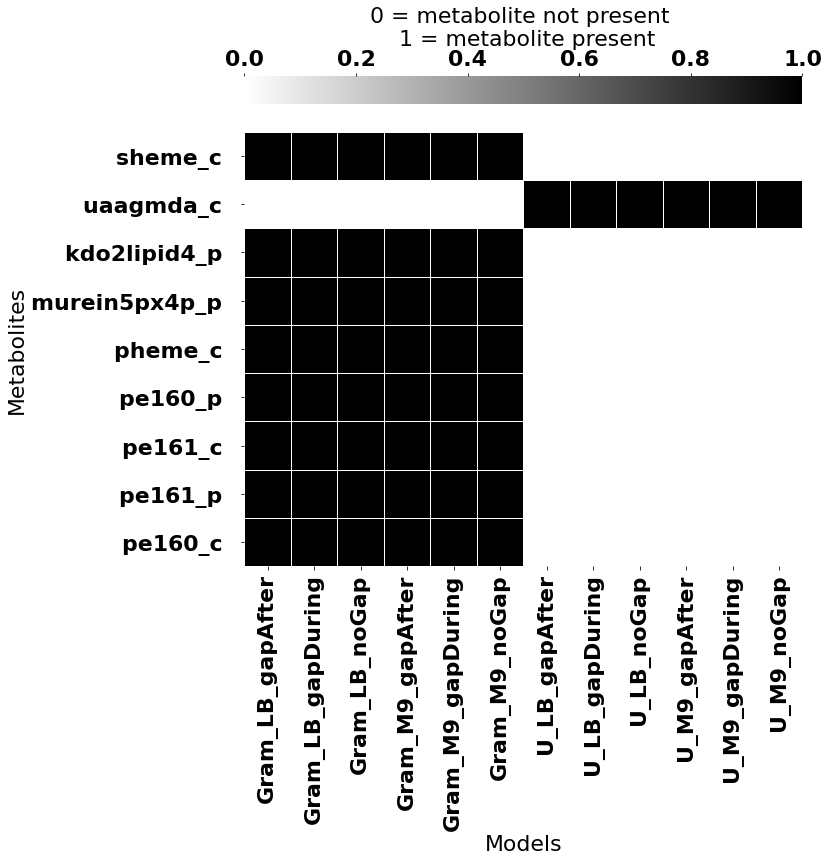

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))

font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

s=sns.heatmap(BinaryGramRxs_binarySorted, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not present \n 1 = metabolite present', 'location': 'top'}, linewidths=0.5)

s.set(xlabel='Models', ylabel='Metabolites')

for l in s.xaxis.get_ticklabels()+s.yaxis.get_ticklabels():
    if 'Neuro' in l.get_text():
        l.set_color('m')

plt.savefig('blackWhite_GramRxsDifferences_corrected.png')

<!-- #### blocked biomass precursors IN MEMOTE, RESULTS ARE DIFFERENT... THEY SAY THEY ADD A TEMPORARY DEMAND REACTION... THAT'S WHAT MAY BE MISSING HERE... -->